<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [147]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [148]:
# setting the random seed for similar results on each run
np.random.seed(7)

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [149]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Data From CSV File  

In [150]:
df = pd.read_csv(r"C:\Users\Ami\Documents\IBM Data Science\loan_train.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [151]:
df.shape

(346, 10)

### Convert to date time object 

In [152]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [153]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [154]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

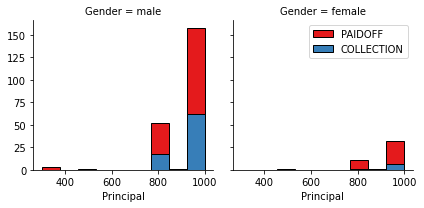

In [155]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

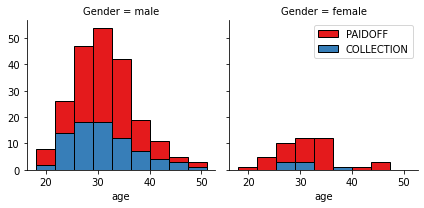

In [156]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

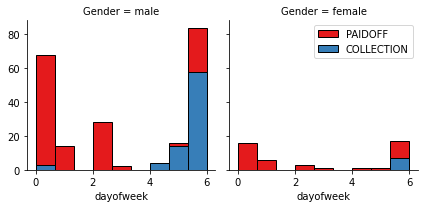

In [157]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### Lets look at the Months people get the loan 

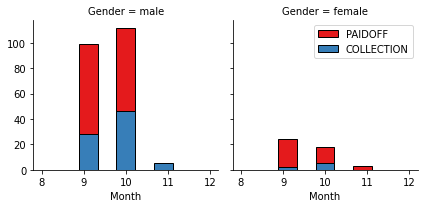

In [158]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### there is higher possibility that people pay off the loan in 9th month than paying it in 10th or 11th

### **as the observation shows people who get the loan at the end of the week don't pay it off, so lets use Feature binarization to set a threshold values less then day 4**

In [159]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


## Convert Categorical features to numerical values

Lets look at gender:

In [160]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [161]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [162]:
df['deadline']=df['due_date']-df['effective_date']

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29 days


In [163]:
df['deadline']=df['deadline'].dt.days
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14


### *based on the tested rusults columns Month and deadline doesn't improve the result so we will not use them in feature sets of training

## One Hot Encoding  
#### How about education?

In [164]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

**There are only two people with Master or Above degress,one of them has paid off the loan and the other one hasn't.As a result keeping 'Master or Above' in our data set wont't help much! so we drop it.**

In [165]:
len(df[df.education=='Master or Above'])

2

#### We use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [166]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


## Feature selection

### Our data without label

In [167]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


### Our labels

In [168]:
# We encode our labels as 0 and 1 s
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## Normalize Data 

Data Standardization give data zero mean and unit variance 

In [169]:
X= preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

In [170]:
# import scoring methods
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [171]:
# our data for training (used '_train' just for improving readability)
X_train, y_train=X,y

In [172]:
X_train.shape, y_train.shape

((346, 9), (346,))

In [173]:
# a dictionary for keeping all scores of the classifiers
trainScores={}

# K Nearest Neighbor(KNN)

In [174]:
from sklearn.neighbors import KNeighborsClassifier

bestScore=0.0
accList=[]

for k in range(3,12):
    
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    # using 10 fold cross validation for scoring the classifier's accuracy
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score=scores.mean()
    accList.append(score)
    
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
        
print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
clf_knn=best_clf

Best K is : 8 | Cross validation Accuracy : 0.7522689075630252


In [175]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)

In [176]:
trainScores['KNN-jaccard']=jaccard_score(y_train, y_pred)
trainScores['KNN-f1-score']=f1_score(y_train, y_pred, average='weighted')  

In [177]:
trainScores

{'KNN-jaccard': 0.297029702970297, 'KNN-f1-score': 0.7701843558681992}

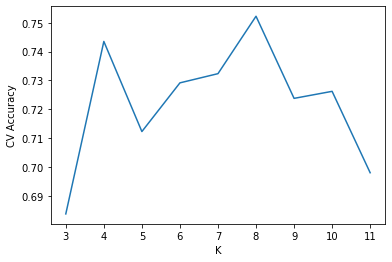

In [178]:
plt.plot(range(3,12),accList)
plt.xlabel('K')
plt.ylabel('CV Accuracy')
plt.show()

# Decision Tree

In [179]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

y_pred=clf_tree.predict(X_train)

In [180]:
trainScores['Tree-jaccard']=jaccard_score(y_train, y_pred)
trainScores['Tree-f1-score']=f1_score(y_train, y_pred, average='weighted')  

In [181]:
trainScores

{'KNN-jaccard': 0.297029702970297,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.7222222222222222,
 'Tree-f1-score': 0.924927020820985}

### Visualizng the tree

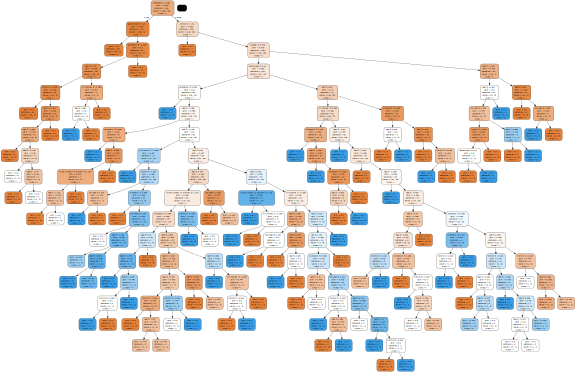

In [182]:
!pip install graphviz
!pip install pydotplus
import graphviz 
import pydotplus

dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                     feature_names=['Principal',
                                    'terms','age',
                                    'Gender',
                                    'weekend',
                                    'Bechalor',
                                    'High School or Below',
                                    'college',
                                    'dayofweek',
                                     #'deadline'
#                                     ,'Month'
                                   ],  
                     class_names='loan_status',  
                     filled=True, rounded=True,  
                     special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"8,8!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph 

# Support Vector Machine

In [183]:
y_train=y_train.astype(float)

In [184]:
from sklearn import svm

clf_svm = svm.LinearSVC(random_state=7)
clf_svm.fit(X_train, y_train)  

y_pred=clf_svm.predict(X_train)

In [185]:
trainScores['SVM-jaccard']=jaccard_score(y_train, y_pred)
trainScores['SVM-f1-score']=f1_score(y_train, y_pred, average='weighted')  

In [186]:
trainScores

{'KNN-jaccard': 0.297029702970297,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.7222222222222222,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.054945054945054944,
 'SVM-f1-score': 0.6689062277741139}

# Logistic Regression

In [187]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [188]:

trainScores['LogReg-logLoss']=log_loss(testy, proba)

trainScores['LogReg-jaccard']=jaccard_score(y_train, y_pred)
trainScores['LogReg-f1-score']=f1_score(y_train, y_pred, average='weighted')  
trainScores['LogReg-logLoss']=log_loss(y_train, y_proba)

In [189]:
trainScores

{'KNN-jaccard': 0.297029702970297,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.7222222222222222,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.054945054945054944,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-logLoss': 0.43174993676801543,
 'LogReg-jaccard': 0.14583333333333334,
 'LogReg-f1-score': 0.7088399037150602}

# Model Evaluation using Test set

In [190]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Test set for evaluation 

In [191]:
test_df = pd.read_csv(r"C:\Users\Ami\Documents\IBM Data Science\loan_train.csv")
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [192]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# test_df['Month'] = test_df.due_date.dt.month 

# test_df['deadline']=test_df['due_date']-test_df['effective_date']
# test_df['deadline']=test_df['deadline'].dt.days

Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X)

In [193]:
testScores={}

In [194]:
knn_pred=clf_knn.predict(testX)
testScores['KNN-jaccard']=jaccard_score(testy, knn_pred)
testScores['KNN-f1-score']=f1_score(testy, knn_pred, average='weighted')  

In [195]:
tree_pred=clf_tree.predict(testX)
testScores['Tree-jaccard']=jaccard_score(testy, tree_pred)
testScores['Tree-f1-score']=f1_score(testy, tree_pred, average='weighted')  

In [196]:
svm_pred=clf_svm.predict(testX)
testScores['SVM-jaccard']=jaccard_score(testy, svm_pred)
testScores['SVM-f1-score']=f1_score(testy, svm_pred, average='weighted')  

In [197]:
log_pred=clf_log.predict(testX)
proba=clf_log.predict_proba(testX)
testScores['LogReg-jaccard']=jaccard_score(testy, log_pred)
testScores['LogReg-f1-score']=f1_score(testy, log_pred, average='weighted')  
testScores['LogReg-logLoss']=log_loss(testy, proba)

In [198]:
trainScores

{'KNN-jaccard': 0.297029702970297,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.7222222222222222,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.054945054945054944,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-logLoss': 0.43174993676801543,
 'LogReg-jaccard': 0.14583333333333334,
 'LogReg-f1-score': 0.7088399037150602}

In [199]:
testScores

{'KNN-jaccard': 0.297029702970297,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.7222222222222222,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.054945054945054944,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-jaccard': 0.14583333333333334,
 'LogReg-f1-score': 0.7088399037150602,
 'LogReg-logLoss': 0.43174993676801543}

In [200]:
# Features used
list(Feature.columns)

['Principal',
 'terms',
 'age',
 'Gender',
 'weekend',
 'dayofweek',
 'Bechalor',
 'High School or Below',
 'college']

# Reports

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7407  | 0.7144   | NA      |
| Decision Tree      | 0.7592  | 0.7618   | NA      |
| SVM                | 0.7592  | 0.6959   | NA      |
| LogisticRegression | 0.7777  | 0.7089   | 0.4947  |

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.2970  | 0.7701   | NA      |
| Decision Tree      | 0.7702  | 0.9249   | NA      |
| SVM                | 0.0549  | 0.6689   | NA      |
| LogisticRegression | 0.1458  | 0.7088   | 0.4317  |

### The result of the Decision tree had shown a relatively good result in trainig. However, Logistic Regression out-performs other models in test  .

#### out tree model suffers from over-fitting